<a href="https://colab.research.google.com/github/seonleeuni/mge51101-20205196/blob/master/RNN_GRU_with_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

## Making Synthetic time-series example

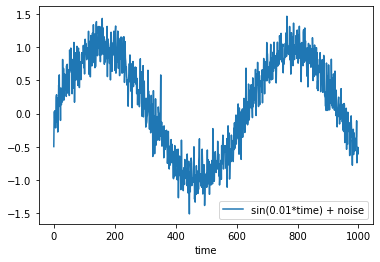

In [12]:
import torch

T = 1000
time = torch.arange(0.0, T)
X = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
plt.plot(time.numpy(),X.numpy(), label = "sin(0.01*time) + noise")
plt.legend()
plt.xlabel('time')
plt.show()

RNN 수행할 때 345번(training part)를 잘 보라는데 , 타임시리즈 데이터 적용시키려면


In [13]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader



#time stamp
tau = 4


features = torch.zeros((T-tau,tau))

#input = features
for i in range(tau):
  features[:,i] = X[i:(T-tau+i)]

input_len = features.size()[1]


#estimate
estimate = torch.zeros((T-tau,tau))
#features.size()

features.size()
features[1]

tensor([-0.0812,  0.0311, -0.0725,  0.0421])

In [0]:
#model making RNN
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.relu = nn.ReLU()

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, inputs, hidden):
        
        inputs = inputs.view(1, 1, -1) # (batch_size, seq_size, n_hidden)
        hidden = hidden.view(self.num_layers, 1, -1)

        output, hidden = self.rnn(inputs, hidden)
        output = self.relu(output[:,-1])
        output = self.fc(output)

        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
# Hyperparameters
n_hidden = input_len - 1
lr = 0.01
epochs = 300
train_num = 600

model = RNN(input_len, n_hidden, 1, input_len)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [33]:
# training
for epoch in range(epochs):
    model.zero_grad()
    running_loss = 0
    hidden = model.initHidden()
    
    for idx in range(features.size()[0]-1):
        inputs = features[idx:idx+1,:].reshape(1, 1, -1)
        output, hidden = model(inputs, hidden) 
       
        target = features[idx+1]

        loss = criterion(output.view(-1),target.view(-1))
        running_loss += loss

    running_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("loss: {:.5f}".format(running_loss.data))

loss: 436.42114
loss: 40.34580
loss: 34.96752


torch.Size([996, 4])

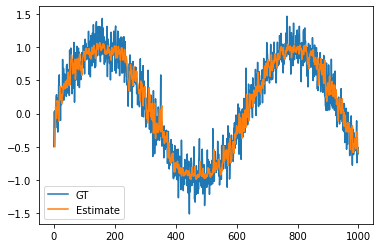

In [34]:
# validation
estimate[0] = features[0]
for idx in range(features.size()[0]-1):
        inputs = features[idx:idx+1,:].reshape(1, 1, -1)
        output, hidden = model(inputs, hidden) 
        estimate[idx+1] = output
plt.plot(time.numpy(), X.numpy(), label='GT');
#plt.plot(time[tau:].numpy(), estimate[:,0].detach().numpy(), label='Estimate');
plt.plot(time[tau:].numpy(), estimate[:,0].detach().numpy(), label='Estimate');
plt.legend()
estimate.size()

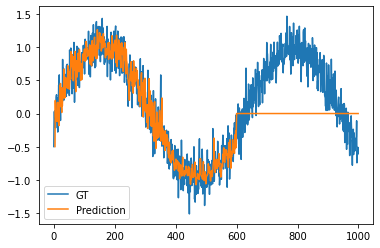

In [30]:
#prediction: use y hat instead real data
predictions = torch.zeros_like(estimate)
predictions[:(train_num - tau)] = estimate[:(train_num - tau)]

for i in range((train_num - tau), (T - tau)):
        inputs = estimate[idx:idx+1,:].reshape(1, 1, -1)
        output, hidden = model(inputs, hidden) 
        estimate[idx+1] = output

plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), predictions[:,0].detach().numpy(), label='Prediction');
plt.legend();

In [0]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, inputs, hidden):
        
        inputs = inputs.view(1, 1, -1) # (batch_size, seq_size, n_hidden)
        hidden = hidden.view(self.num_layers, 1, -1)

        output, hidden = self.gru(inputs, hidden)
        output = self.fc(self.relu(output[:,-1]))

        return output, hidden
    
    def initHidden(self):
       # weight = next(self.parameters()).data
        #hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return torch.zeros(1, self.hidden_size)

In [0]:
n_hidden = input_len - 1
lr = 0.01
epochs = 300

model = GRU(input_len, n_hidden, 1, input_len)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
# training
for epoch in range(epochs):
    model.zero_grad()
    running_loss = 0
    hidden = model.initHidden()
    
    for idx in range(features.size()[0]-1):
        inputs = features[idx:idx+1,:].reshape(1, 1, -1)
        output, hidden = model(inputs, hidden) 
       
        target = features[idx+1]

        loss = criterion(output.view(-1),target.view(-1))
        running_loss += loss

    running_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("loss: {:.5f}".format(running_loss.data))

loss: 596.68475
loss: 67.25663
loss: 39.50270


torch.Size([996, 4])

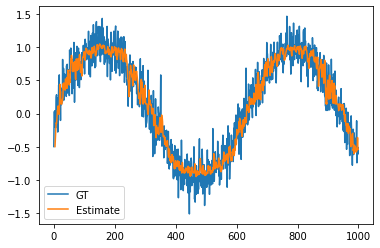

In [24]:
# validation
estimate[0] = features[0]
for idx in range(features.size()[0]-1):
        inputs = features[idx:idx+1,:].reshape(1, 1, -1)
        output, hidden = model(inputs, hidden) 
        estimate[idx+1] = output
plt.plot(time.numpy(), X.numpy(), label='GT');
#plt.plot(time[tau:].numpy(), estimate[:,0].detach().numpy(), label='Estimate');
plt.plot(time[tau:].numpy(), estimate[:,0].detach().numpy(), label='Estimate');
plt.legend()
estimate.size()

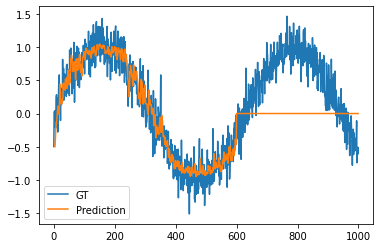

In [25]:
#prediction: use y hat instead real data
predictions = torch.zeros_like(estimate)
predictions[:(train_num - tau)] = estimate[:(train_num - tau)]

for i in range((train_num - tau), (T - tau)):
        inputs = estimate[idx:idx+1,:].reshape(1, 1, -1)
        output, hidden = model(inputs, hidden) 
        estimate[idx+1] = output

plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), predictions[:,0].detach().numpy(), label='Prediction');
plt.legend();